<AxesSubplot:xlabel='product_id'>

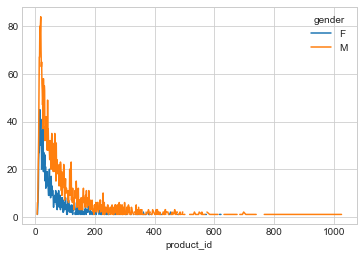

In [8]:
df.groupby(['user_id', 'gender']).product_id.count().reset_index().groupby([
    'product_id',
    'gender',
]).user_id.count().unstack().plot()

In [9]:
df.groupby('gender')['purchase'].mean()

gender
F    8734.565765
M    9437.526040
Name: purchase, dtype: float64

In [10]:
df.describe()

,user_id,occupation,marital_status,product_category,purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,23961.000000


In [11]:
import seaborn as sns

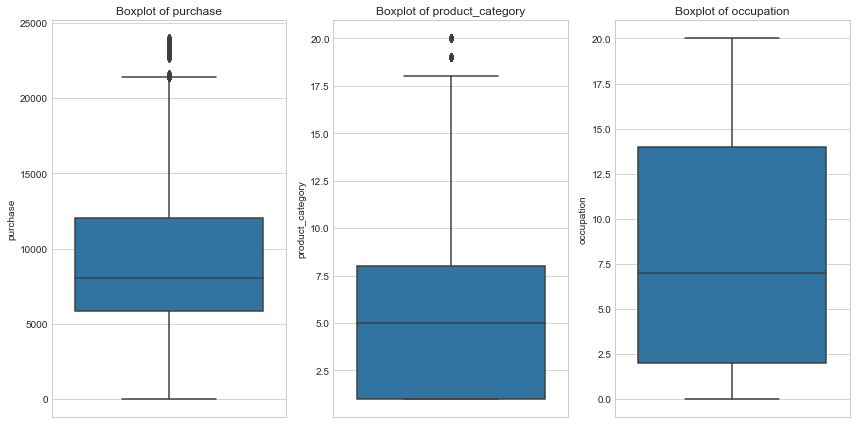

In [12]:
numerical_cols = ['purchase', 'product_category', 'occupation']

plt.figure(figsize=(12,6))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, len(numerical_cols), i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [19]:
def detect_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers_purchase = detect_outliers_iqr(df, 'purchase')
print(f"number of outliers in 'purchase' using iqr method: {len(outliers_purchase)}")

number of outliers in 'purchase' using iqr method: 2677


In [14]:
from scipy.stats import zscore

df['purchase_z'] = zscore(df['purchase'])

outliers_z = df[(df['purchase_z'] > 3) | (df['purchase_z'] < -3)]

print(f"number of outliers in 'purchase' using z-score method: {len(outliers_z)}")

number of outliers in 'purchase' using z-score method: 0


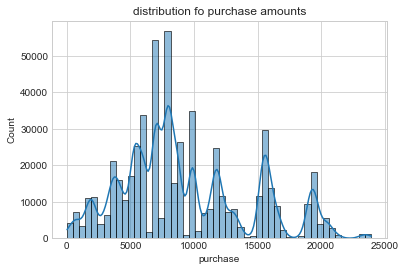

In [15]:
sns.histplot(df['purchase'], bins=50, kde=True)
plt.title('distribution fo purchase amounts')
plt.show()

In [16]:
df.groupby('user_id')['purchase'].describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
1000001,35.0,9545.514286,4639.871552,612.0,7884.50,9946.0,12305.50,19219.0
1000002,77.0,10525.610390,4301.736734,119.0,7818.00,9899.0,11973.00,20657.0
1000003,29.0,11780.517241,5358.428805,3646.0,6953.00,12103.0,15592.00,19631.0
1000004,14.0,14747.714286,5801.640132,481.0,15488.50,15852.5,19087.00,19693.0
1000005,106.0,7745.292453,4110.717354,1938.0,4551.75,6168.0,8823.00,21021.0
...,...,...,...,...,...,...,...,...
1006036,514.0,8007.894942,4403.756640,137.0,5295.50,7483.0,9739.25,23525.0
1006037,122.0,9176.540984,4582.640828,579.0,5946.00,8063.5,12043.25,23714.0
1006038,12.0,7502.833333,3625.373381,365.0,5814.00,6895.5,9031.50,13565.0


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,15))
gender_purchases = df.groupby(['gender', 'purchase']).sum()
sns.boxplot(x='gender', y=gender_purchases, data=df)
plt.xticks(rotation=45)
plt.show()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 720x1080 with 0 Axes>

In [18]:
from scipy.stats import f_oneway

categories = df['gender'].unique()
groups = [df[df['gender'] == category]['purchase'] for category in categories]

f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat}, p-value: {p_value}")

ANOVA F-statistic: 2010.4424717228965, p-value: 0.0


# Runthrough

### Introduction

We want to know whether men spend more than women on Black Friday at Walmart...

In [6]:
# Import appropriate libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Load the data as a dataframe from the csv file
df = pd.read_csv('./walmart_data.csv')

# Make all column names lowercase for sanity
df.columns = [c.lower() for c in df.columns]

# Display the first 5 rows of data to get an idea of what we're working with
df.head()

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category,purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


<AxesSubplot:>

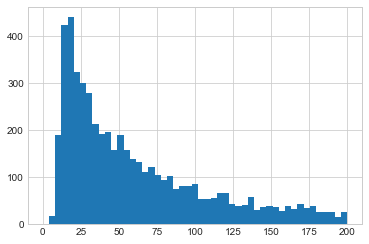

In [11]:
# Look at the number of products bought by users
# Group the data by the user_id and count the number of product_ids each of them have
df.groupby(['user_id'])['product_id'].count().hist(bins=np.linspace(0, 200, 50))

Here we see that most users buy around 20 products with no visible outliers

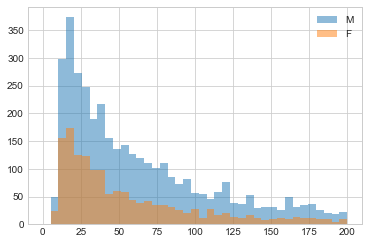

In [42]:
# Next we want to compare these purchase amounts between men and women
# Group the data by user_id and gender and add their respective product_id counts
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        d['M'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='M'),
        d['F'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='F')
    )
)
plt.legend()

Here we can see that the distributions seem comparable between men and women with the men accounting for many more sales

Let's check the number of individual men and women in the data

In [17]:
df.groupby(['gender'])['user_id'].nunique()

gender
F    1666
M    4225
Name: user_id, dtype: int64

There are over two and a half times as many men as there are women, so it makes sense that they are accounting for so many more purchases

We want to normalize these results to control for the population difference between men and women

We have two options to divide by:
- The number of individual transactions for each gender

    - This will give us an idea of what each gender is contributing to the total purchase amount


- The number of unique users for each gender

    - This will give us an idea of the average spending patterns per user, what each individual is likely to do based on gender

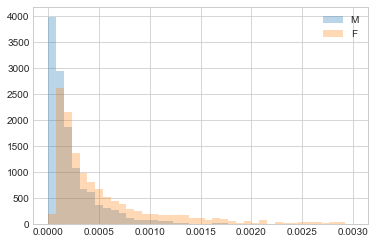

In [44]:
# Divide by the number of transactions per gender to see overall contributions
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        (d['M'] / d['M'].sum()).dropna().hist(bins=np.linspace(0, 0.003, 40), alpha=0.3, label='M', density=True),
        (d['F'] / d['F'].sum()).dropna().hist(bins=np.linspace(0, 0.003, 40), alpha=0.3, label='F', density=True)
    )
)
plt.legend()

Here is looks like many more men have a very small number of purchases but more women consistently have more purchases than men, so they might even out 

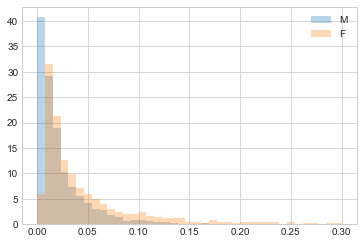

In [45]:
# Divide by the number of users per gender to see individual stats
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        (d['M'] / len(d['M'].dropna())).dropna().hist(bins=np.linspace(0, 0.3, 40), alpha=0.3, label='M', density=True),
        (d['F'] / len(d['F'].dropna())).dropna().hist(bins=np.linspace(0, 0.3, 40), alpha=0.3, label='F', density=True)
    )
)
plt.legend()

A similar result can be seen here

- Sidenote: need to find out what exactly default=True does and do we even need to divide to normalize or can we just use that? Because something very interesting happens when it's used on the original unnormalized graph:

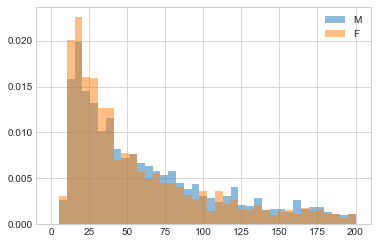

In [49]:
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        d['M'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='M', density=True),
        d['F'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='F', density=True)
    )
)
plt.legend()

Let's generate some heat maps to understand which products men and women are more likely to buy

First raw numbers:

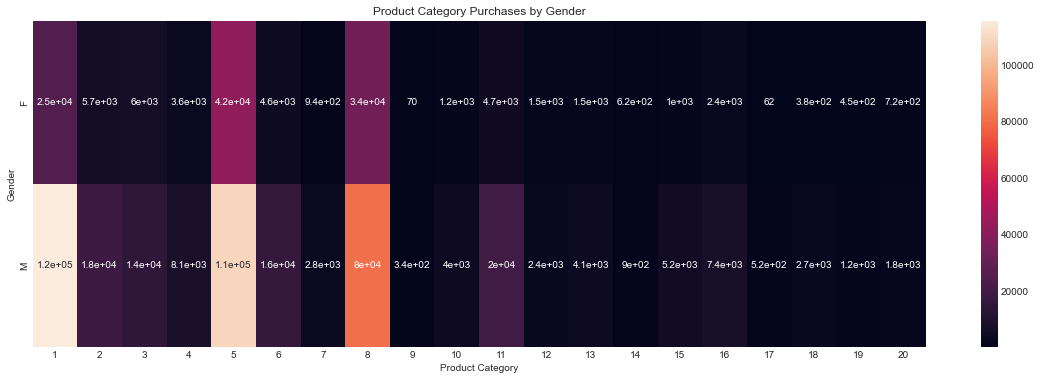

In [62]:
category_gender_counts = df.groupby(['gender', 'product_category'])['purchase'].count().unstack().fillna(0)

# Plot the heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(category_gender_counts, annot=True, cbar=True)

# Add labels and title
plt.title("Product Category Purchases by Gender")
plt.xlabel("Product Category")
plt.ylabel("Gender")
plt.show()

Now normalized:

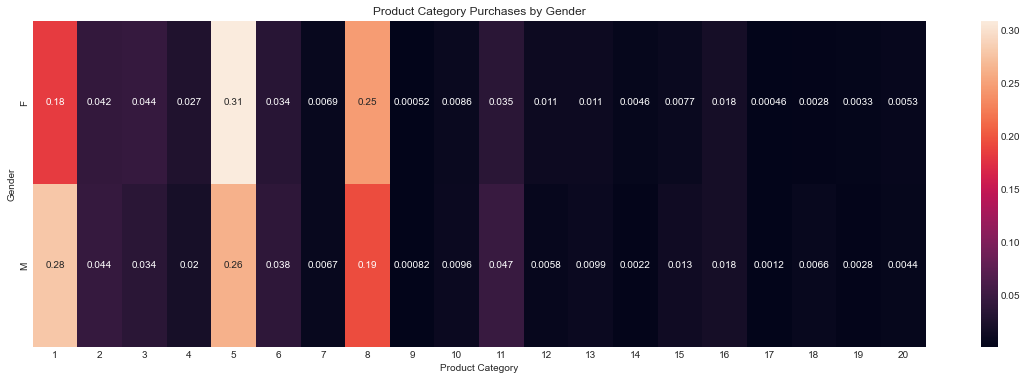

In [64]:
category_gender_counts = category_gender_counts.div(category_gender_counts.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(category_gender_counts, annot=True, cbar=True)

# Add labels and title
plt.title("Product Category Purchases by Gender")
plt.xlabel("Product Category")
plt.ylabel("Gender")
plt.show()

Product categories 1, 5, and 8 are definitely standouts

It looks like men have more purchases in category 1 and women in 5 and 8

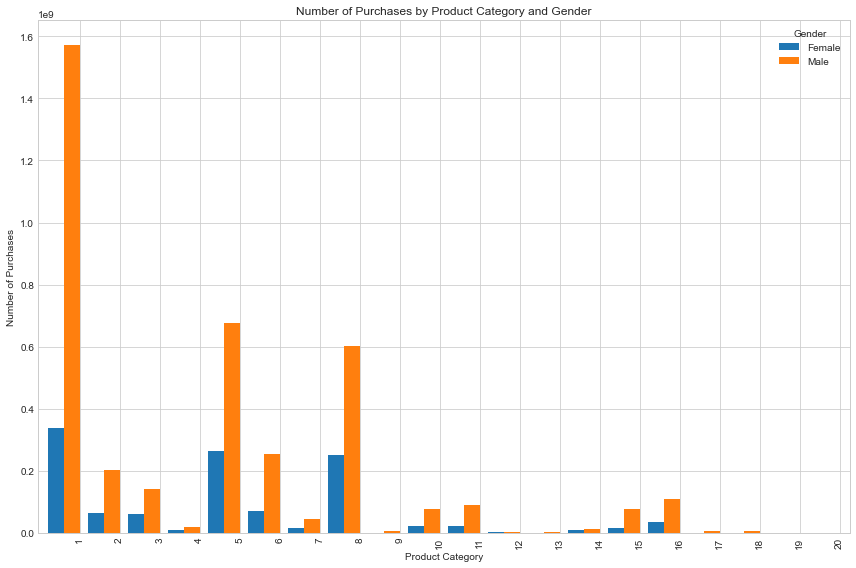

In [76]:
# Group by gender and product_id to count the number of purchases
purchase_counts = df.groupby(['gender', 'product_category'])['purchase'].sum().unstack().fillna(0)

# Plotting a grouped bar chart
purchase_counts.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=1)

# Adding labels and title
plt.title("Number of Purchases by Product Category and Gender")
plt.xlabel("Product Category")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=90)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

# Show the plot
plt.show()

In [70]:
df['product_id'].nunique()

3631

In [71]:
df['product_category'].nunique()

20

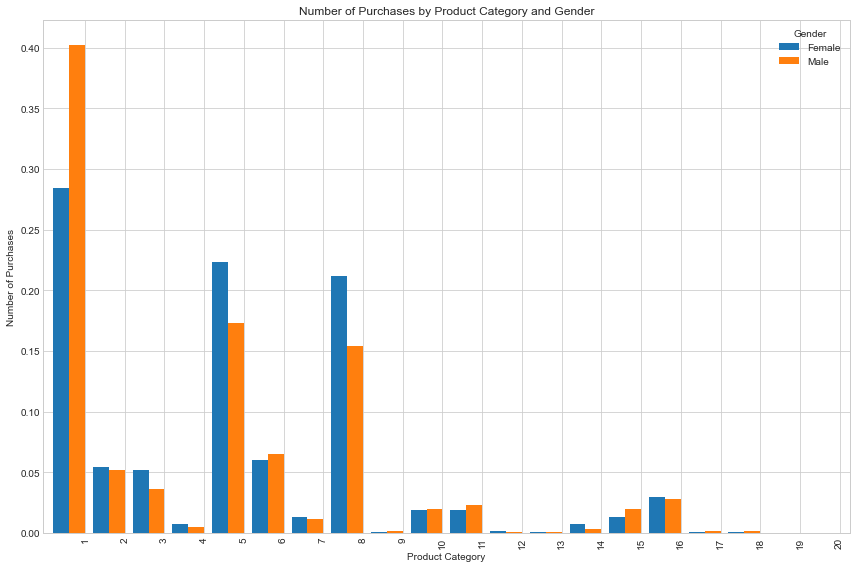

In [75]:
# Normalized

# Group by gender and product_id to count the number of purchases
purchase_counts = df.groupby(['gender', 'product_category'])['purchase'].sum().unstack().fillna(0)
# Normalize
purchase_counts_normalized = purchase_counts.div(purchase_counts.sum(axis=1), axis=0)

# Plotting a grouped bar chart
purchase_counts_normalized.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=1)

# Adding labels and title
plt.title("Number of Purchases by Product Category and Gender")
plt.xlabel("Product Category")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=90)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

# Show the plot
plt.show()